# 과제3
1주차 Auction master 데이터로 회귀분석 (아래 목록들을 포함해야 함)
- 자유롭게 EDA, 전처리
- 변수 제거, 선택 시 이유 설명
- 다중공선성 확인, 처리
- fit된 모델의 평가 (R-square, MSE 등등)
- 선택: 정규화, 변수선택법 등등

In [277]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
%matplotlib inline

matplotlib.rc('font', family='AppleGothic') # 한글 설정
plt.rcParams['axes.unicode_minus'] = False


In [278]:
# 데이터 불러오기 
data = pd.read_csv('Auction_master_train.csv')
data.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,...,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,...,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,...,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,...,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,...,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


## EDA

In [279]:
# 결측치 확인
data.isnull().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_li                        1910
addr_san                          0
addr_bunji1                       4
addr_bunji2                    1044
addr_etc                          0
Apartment_usage             

In [280]:
'''
    # Target 변수인 '낙찰 가격'에 대한 영향력이 미미할 것 같은 변수 삭제
    # Apartment_usage 인코딩 {0: 주상복합, 1: 아파트  }
'''

"\n    # Target 변수인 '낙찰 가격'에 대한 영향력이 미미할 것 같은 변수 삭제\n    # Apartment_usage 인코딩 {0: 주상복합, 1: 아파트  }\n"

---
#### feature 제거


In [281]:
# 리 단위의 거리 차이는 큰 의미가 없을 것이라 판단하여 삭제
del data['addr_li']

In [282]:
# Hammer price에 크게 영향을 미치지 않을 것 같은 변수 삭제
del data['addr_bunji2']
del data['Specific']
del data['Appraisal_company']
del data['addr_etc'] # 층수는 Current_floor 변수에 표현되기 때문
del data['addr_dong'] # 구 기준으로만 판단하기로 결정
del data['road_name']
del data['road_bunji1']
del data['road_bunji2']

# Final_result은 모두 '낙찰'이기 때문에 불필요한 정보라 판단되어 삭제합니다.
del data['Final_result']


---
#### Apartment usage 인코딩
0: 주상복합 <br/>
1: 아파트


In [283]:
data['Apartment_usage'].unique()

array(['주상복합', '아파트'], dtype=object)

In [284]:
data['Apartment_usage'].replace(['주상복합','아파트'],[0,1], inplace=True)

---
#### Auction class 인코딩
0: 임의 <br/>
1: 강제

In [285]:
data['Auction_class'].unique()

array(['임의', '강제'], dtype=object)

In [286]:
data['Auction_class'].replace(['임의','강제'],[0,1], inplace=True)

---
#### Bid class 인코딩
더미 데이터를 통해 생성


In [287]:
data['Bid_class'].unique()

array(['개별', '일반', '일괄'], dtype=object)

In [288]:
dummy_bidClass = pd.get_dummies(data.Bid_class)
dummy_bidClass.head()

,개별,일괄,일반
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [289]:
data = pd.concat([data.drop(['Bid_class'],axis=1), dummy_bidClass],axis=1 )
data.head()

,Auction_key,Auction_class,Claim_price,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,...,Current_floor,Share_auction_YorN,Close_date,Close_result,point.y,point.x,Hammer_price,개별,일괄,일반
0,2687,0,1766037301,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,...,5,N,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000,1,0,0
1,2577,0,152946867,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,...,51,N,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999,0,0,1
2,2197,0,11326510,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,...,14,N,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999,1,0,0
3,2642,0,183581724,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,...,11,N,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000,0,0,1
4,1958,1,45887671,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,...,7,N,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000,0,0,1


---
#### addr_do 인코딩
0: 부산 <br/>
1: 서울

In [290]:
data['addr_do'].unique()

array(['부산', '서울'], dtype=object)

In [291]:
data['addr_do'].replace(['부산','서울'],[0,1], inplace=True)

---
#### Close result 인코딩
0: '    ' <br/>
1: 배당

In [292]:
data['Close_result'].unique()

array(['배당', '    '], dtype=object)

In [293]:
data['Close_result'].replace(['    ','배당'],[0,1], inplace=True)

---
#### Share auction 인코딩
0: N <br/>
1: Y

In [294]:
data['Share_auction_YorN'].unique()

array(['N', 'Y'], dtype=object)

In [295]:
data['Share_auction_YorN'].replace(['N','Y'],[0,1], inplace=True)

---
#### 날짜 데이터 인코딩


In [296]:
from datetime import datetime
# Appraisal_date, Close_date,
# First_auction_date, Final_auction_date,
# Preserve_regist_date의 string을 날짜데이터로

# 1. Appraisal_date
data['Appraisal_date'] = pd.to_datetime(data['Appraisal_date']).astype(np.int64)

In [297]:
data['Appraisal_date'].head()

0    1501027200000000000
1    1473638400000000000
2    1479772800000000000
3    1481587200000000000
4    1457308800000000000
Name: Appraisal_date, dtype: int64

In [298]:
# 2. Close_date
# Close_date에 이상한 값이 있으므로 제거한 후 string을 날짜데이터로
print(data['Close_date'].min())

1111-11-11 00:00:00


In [299]:
data = data[data['Close_date'] != '1111-11-11 00:00:00']
data.head()

,Auction_key,Auction_class,Claim_price,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,...,Current_floor,Share_auction_YorN,Close_date,Close_result,point.y,point.x,Hammer_price,개별,일괄,일반
0,2687,0,1766037301,1501027200000000000,2,1,12592.0,37.35,37.35,181.77,...,5,0,2018-06-14 00:00:00,1,35.162717,129.137048,760000000,1,0,0
1,2577,0,152946867,1473638400000000000,2,1,42478.1,18.76,18.76,118.38,...,51,0,2017-03-30 00:00:00,1,35.156633,129.145068,971889999,0,0,1
2,2197,0,11326510,1479772800000000000,3,2,149683.1,71.00,71.00,49.94,...,14,0,2017-12-13 00:00:00,1,35.184601,128.996765,93399999,1,0,0
3,2642,0,183581724,1481587200000000000,2,1,24405.0,32.98,32.98,84.91,...,11,0,2017-12-27 00:00:00,1,35.154180,129.089081,256899000,0,0,1
4,1958,1,45887671,1457308800000000000,2,1,774.0,45.18,45.18,84.96,...,7,0,2016-10-04 00:00:00,1,35.099630,128.998874,158660000,0,0,1


In [300]:
data['Close_date'].min()

'2016-05-19 00:00:00'

In [301]:
data['Close_date'] = pd.to_datetime(data['Close_date']).astype(np.int64)

In [302]:
data['Close_date'].head()

0    1528934400000000000
1    1490832000000000000
2    1513123200000000000
3    1514332800000000000
4    1475539200000000000
Name: Close_date, dtype: int64

In [303]:
# Close_date의 이상치를 제거하면서 Close_result의 고유값도 하나로 줄어들었음
data['Close_result'].unique()

array([1])

In [304]:
# 불필요한 정보이므로 삭제한다.
del data['Close_result']

In [305]:
# 3. First_auction_date
data['First_auction_date'] = pd.to_datetime(data['First_auction_date']).astype(np.int64)

In [306]:
data['First_auction_date'].head()

0    1518480000000000000
1    1482969600000000000
2    1501200000000000000
3    1500508800000000000
4    1467763200000000000
Name: First_auction_date, dtype: int64

In [307]:
# 4. Final_auction_date
data['Final_auction_date'] = pd.to_datetime(data['Final_auction_date']).astype(np.int64)

In [308]:
data['Final_auction_date'].head()

0    1521504000000000000
1    1485993600000000000
2    1507852800000000000
3    1509580800000000000
4    1470182400000000000
Name: Final_auction_date, dtype: int64

In [309]:
# 5. Preserve_regist_date
# Preserve_regist_date에 이상한 값이 있으므로 제거한 후 string을 날짜데이터로

data['Preserve_regist_date'].min()

'1111-11-11 00:00:00'

In [310]:
data = data[data['Preserve_regist_date'] != '1111-11-11 00:00:00']
data.head()

,Auction_key,Auction_class,Claim_price,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,...,Total_floor,Current_floor,Share_auction_YorN,Close_date,point.y,point.x,Hammer_price,개별,일괄,일반
0,2687,0,1766037301,1501027200000000000,2,1,12592.0,37.35,37.35,181.77,...,45,5,0,1528934400000000000,35.162717,129.137048,760000000,1,0,0
1,2577,0,152946867,1473638400000000000,2,1,42478.1,18.76,18.76,118.38,...,70,51,0,1490832000000000000,35.156633,129.145068,971889999,0,0,1
2,2197,0,11326510,1479772800000000000,3,2,149683.1,71.00,71.00,49.94,...,15,14,0,1513123200000000000,35.184601,128.996765,93399999,1,0,0
3,2642,0,183581724,1481587200000000000,2,1,24405.0,32.98,32.98,84.91,...,20,11,0,1514332800000000000,35.154180,129.089081,256899000,0,0,1
4,1958,1,45887671,1457308800000000000,2,1,774.0,45.18,45.18,84.96,...,7,7,0,1475539200000000000,35.099630,128.998874,158660000,0,0,1


In [311]:
data['Preserve_regist_date'].min()

'1969-12-31 00:00:00'

In [312]:
data['Preserve_regist_date'] = pd.to_datetime(data['Preserve_regist_date']).astype(np.int64)

In [313]:
data['Preserve_regist_date'].head()

0    1247529600000000000
1    1323993600000000000
2     712540800000000000
3     994982400000000000
4    1006819200000000000
Name: Preserve_regist_date, dtype: int64

---
#### Creditor 인코딩


In [314]:
# Private과 그렇지 않은 유형으로 구분
data['Creditor'].loc[data.Creditor != 'Private'] = 'Non-Private'

In [315]:
data['Creditor'].unique()

array(['Non-Private', 'Private'], dtype=object)

In [316]:
data['Creditor'].replace({'Private':0, 'Non-Private':1}, inplace=True)

In [317]:
data['Creditor'].head()

0    1
1    1
2    1
3    1
4    0
Name: Creditor, dtype: int64

---
#### addr_san 인코딩

In [318]:
data['addr_san'].unique()

array(['N', 'Y'], dtype=object)

In [319]:
data['addr_san'].replace({'N':0, 'Y':1}, inplace=True)
data['addr_san'].head()

0    0
1    0
2    0
3    0
4    0
Name: addr_san, dtype: int64

---
#### addr_si 인코딩


In [320]:
data['addr_si'].unique()

array(['해운대구', '사상구', '남구', '사하구', '영도구', '서구', '부산진구', '연제구', '수영구',
       '동래구', '동구', '중구', '강서구', '북구', '금정구', '기장군', '강남구', '은평구', '서초구',
       '영등포구', '양천구', '마포구', '금천구', '성동구', '노원구', '서대문구', '용산구', '구로구',
       '강북구', '관악구', '송파구', '도봉구', '광진구', '중랑구', '동대문구', '강동구', '성북구',
       '동작구', '종로구'], dtype=object)

In [321]:
'''
    지역별 아파트 평당가 랭킹을 검색
    
    <서울>
    총 25개 구 중 평당가가 3000만원 이상인
    강남/서초/용산/송파/성동 을 1, 나머지를 0으로 인코딩
    
    <부산>
    총 16개 구 중 평당가가 950만원 이상인
    수영/해운대/연제/동래/금정 을 1, 나머지를 0으로 인코딩
    
    >> 아파트/주상복합 등의 기준으로도 나눠야 하고, 서울 중구/부산 중구 등의 구분도 필요하지만
       분석의 방향만 잡아보자는 취지로 생략하였습니다.
       
    [출처] http://buking.kr/
'''

'\n    지역별 아파트 평당가 랭킹을 검색\n    \n    <서울>\n    총 25개 구 중 평당가가 3000만원 이상인\n    강남/서초/용산/송파/성동 을 1, 나머지를 0으로 인코딩\n    \n    <부산>\n    총 16개 구 중 평당가가 950만원 이상인\n    수영/해운대/연제/동래/금정 을 1, 나머지를 0으로 인코딩\n    \n    >> 아파트/주상복합 등의 기준으로도 나눠야 하고, 서울 중구/부산 중구 등의 구분도 필요하지만\n       분석의 방향만 잡아보자는 취지로 생략하였습니다.\n       \n    [출처] http://buking.kr/\n'

In [322]:
# 서울
data['addr_si'].loc[data.addr_si == '강남구'] = 1
data['addr_si'].loc[data.addr_si == '서초구'] = 1
data['addr_si'].loc[data.addr_si == '용산구'] = 1
data['addr_si'].loc[data.addr_si == '송파구'] = 1
data['addr_si'].loc[data.addr_si == '성동구'] = 1

# 부산
data['addr_si'].loc[data.addr_si == '수영구'] = 1
data['addr_si'].loc[data.addr_si == '해운대구'] = 1
data['addr_si'].loc[data.addr_si == '연제구'] = 1
data['addr_si'].loc[data.addr_si == '동래구'] = 1
data['addr_si'].loc[data.addr_si == '금정구'] = 1

data['addr_si'].loc[data.addr_si != 1] = 0

In [323]:
data['addr_si'].unique()

array([1, 0])

---
#### addr_bunji1 결측값 채우기


In [324]:
# 평균값으로 채워보았습니다.
data['addr_bunji1'].fillna(value=data.addr_bunji1.mean(), inplace=True)

In [325]:
data['addr_bunji1'].isnull().sum()

0

In [326]:
# 인코딩 결과 확인
print(data.dtypes)

Auction_key                      int64
Auction_class                    int64
Claim_price                      int64
Appraisal_date                   int64
Auction_count                    int64
Auction_miscarriage_count        int64
Total_land_gross_area          float64
Total_land_real_area           float64
Total_land_auction_area        float64
Total_building_area            float64
Total_building_auction_area    float64
Total_appraisal_price            int64
Minimum_sales_price              int64
First_auction_date               int64
Final_auction_date               int64
Creditor                         int64
addr_do                          int64
addr_si                          int64
addr_san                         int64
addr_bunji1                    float64
Apartment_usage                  int64
Preserve_regist_date             int64
Total_floor                      int64
Current_floor                    int64
Share_auction_YorN               int64
Close_date               

---
## 회귀분석

In [327]:
data.head()

,Auction_key,Auction_class,Claim_price,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,...,Total_floor,Current_floor,Share_auction_YorN,Close_date,point.y,point.x,Hammer_price,개별,일괄,일반
0,2687,0,1766037301,1501027200000000000,2,1,12592.0,37.35,37.35,181.77,...,45,5,0,1528934400000000000,35.162717,129.137048,760000000,1,0,0
1,2577,0,152946867,1473638400000000000,2,1,42478.1,18.76,18.76,118.38,...,70,51,0,1490832000000000000,35.156633,129.145068,971889999,0,0,1
2,2197,0,11326510,1479772800000000000,3,2,149683.1,71.00,71.00,49.94,...,15,14,0,1513123200000000000,35.184601,128.996765,93399999,1,0,0
3,2642,0,183581724,1481587200000000000,2,1,24405.0,32.98,32.98,84.91,...,20,11,0,1514332800000000000,35.154180,129.089081,256899000,0,0,1
4,1958,1,45887671,1457308800000000000,2,1,774.0,45.18,45.18,84.96,...,7,7,0,1475539200000000000,35.099630,128.998874,158660000,0,0,1


In [328]:
data_x = data.drop(['Hammer_price'], axis=1)
data_y = pd.DataFrame(data['Hammer_price'],columns=['Hammer_price'])

In [329]:
print(data_x.columns.values)
print(data_y.columns.values)

['Auction_key' 'Auction_class' 'Claim_price' 'Appraisal_date'
 'Auction_count' 'Auction_miscarriage_count' 'Total_land_gross_area'
 'Total_land_real_area' 'Total_land_auction_area' 'Total_building_area'
 'Total_building_auction_area' 'Total_appraisal_price'
 'Minimum_sales_price' 'First_auction_date' 'Final_auction_date'
 'Creditor' 'addr_do' 'addr_si' 'addr_san' 'addr_bunji1' 'Apartment_usage'
 'Preserve_regist_date' 'Total_floor' 'Current_floor' 'Share_auction_YorN'
 'Close_date' 'point.y' 'point.x' '개별' '일괄' '일반']
['Hammer_price']


In [330]:
# 상관계수 행렬
data_x.corr()

,Auction_key,Auction_class,Claim_price,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,...,Preserve_regist_date,Total_floor,Current_floor,Share_auction_YorN,Close_date,point.y,point.x,개별,일괄,일반
Auction_key,1.000000,0.010556,-0.134938,0.307015,-0.037437,-0.028587,-0.021657,-0.172414,-0.153950,-0.234452,...,0.015170,0.139419,0.095034,-0.046527,0.208512,-0.815508,0.831828,-0.052441,-0.046613,0.063902
Auction_class,0.010556,1.000000,-0.066816,0.036349,0.000698,-0.003679,-0.040903,-0.092394,-0.139362,-0.119775,...,-0.119359,-0.089960,-0.018264,0.210759,0.018779,-0.014926,0.017638,0.099946,0.031557,-0.105289
Claim_price,-0.134938,-0.066816,1.000000,-0.145274,-0.016701,-0.018709,0.006418,0.139486,0.143850,0.186869,...,-0.004569,0.018738,0.046524,-0.029999,0.024464,0.101615,-0.109567,0.273067,0.019756,-0.268522
Appraisal_date,0.307015,0.036349,-0.145274,1.000000,-0.146007,-0.105814,0.006539,-0.024371,-0.039165,-0.064807,...,0.032678,0.042264,-0.000953,0.066466,0.737947,-0.140787,0.145430,-0.109932,-0.028755,0.114094
Auction_count,-0.037437,0.000698,-0.016701,-0.146007,1.000000,0.969209,-0.032947,0.032361,0.030821,0.104671,...,0.112793,-0.043840,-0.029788,0.024539,0.017660,-0.009882,0.004952,0.031773,-0.010473,-0.027566
Auction_miscarriage_count,-0.028587,-0.003679,-0.018709,-0.105814,0.969209,1.000000,-0.038004,0.041769,0.039291,0.128353,...,0.124615,-0.035593,-0.022970,0.030382,0.028435,-0.011032,0.004982,0.023808,-0.007819,-0.020663
Total_land_gross_area,-0.021657,-0.040903,0.006418,0.006539,-0.032947,-0.038004,1.000000,0.169108,0.163226,0.072993,...,-0.013278,0.098923,0.094242,-0.001176,-0.004101,0.012388,-0.011617,-0.048228,0.012834,0.042723
Total_land_real_area,-0.172414,-0.092394,0.139486,-0.024371,0.032361,0.041769,0.169108,1.000000,0.968435,0.581097,...,-0.123625,-0.152862,-0.105850,0.004006,-0.026450,0.107042,-0.108454,-0.116080,0.068965,0.091865
Total_land_auction_area,-0.153950,-0.139362,0.143850,-0.039165,0.030821,0.039291,0.163226,0.968435,1.000000,0.566626,...,-0.094243,-0.139169,-0.100443,-0.214477,-0.038173,0.092780,-0.094197,-0.105003,0.071348,0.080517
Total_building_area,-0.234452,-0.119775,0.186869,-0.064807,0.104671,0.128353,0.072993,0.581097,0.566626,1.000000,...,0.125785,0.329653,0.251956,-0.011118,-0.037226,0.116458,-0.117611,-0.104443,0.056413,0.084280


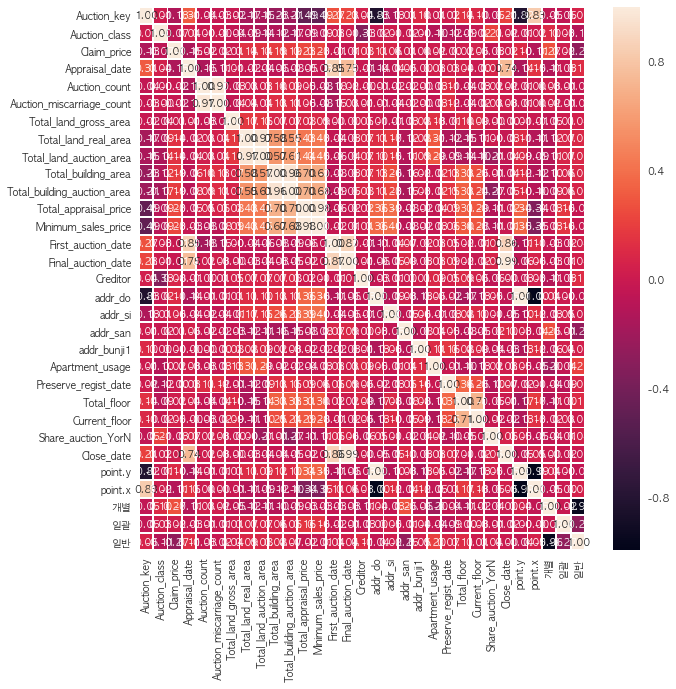

In [331]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data_x.corr(), annot=True,
           fmt='.2f', linewidths=.9)

In [332]:
# 다중공선성 측정
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data_x.values, i) for i in range(data_x.shape[1])]

vif['features'] = data_x.columns
vif.sort_values(['VIF Factor'], ascending=[False])

,VIF Factor,features
14,74.403660,Final_auction_date
25,70.532792,Close_date
11,26.039701,Total_appraisal_price
12,25.767211,Minimum_sales_price
13,6.895975,First_auction_date
3,3.860389,Appraisal_date
5,2.076776,Auction_miscarriage_count
10,2.035576,Total_building_auction_area
4,2.008518,Auction_count
9,2.004221,Total_building_area


---
## Modeling

In [333]:
# train, test data 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x,data_y, test_size=0.2, random_state=0)

In [334]:
from sklearn.linear_model import LinearRegression

# 모델 불러오기
model = LinearRegression()

# train data에 fit시킴
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [335]:
# fit된 모델의 R-square
model.score(x_train, y_train)

0.985303138931018

In [336]:
# MSE 
import sklearn as sk
sk.metrics.mean_squared_error(y_train, model.predict(x_train))

2825554942552948.5

In [337]:
print(model.coef_) # 추정된 회귀계수 (intercept 제외)
print(model.intercept_)

[[-9.57353739e+03  4.31140256e+01  2.08966295e-03 -1.12822234e-10
  -4.81159172e-03  6.59494602e-01  2.31936361e+01 -1.09239410e+01
  -2.32992017e+01 -8.76050644e+01 -1.15382866e+02  1.74264384e-01
   9.05207105e-01 -1.61582880e-10  9.77473503e-10 -2.77322723e-01
   5.13697514e+00 -4.42710749e-01  5.27809487e-02  8.08492509e+02
   3.02674773e-01 -1.47738551e-11 -4.33278649e+01 -3.24788547e+01
   3.89257952e-01 -5.15493272e-10  1.21203718e+01 -1.07781161e+01
   2.66095645e-02 -4.69803604e-02  2.03707959e-02]]
[-2.42641062e+08]


In [338]:
# test 데이터 예측
model.predict(x_test)

array([[2.00133642e+08],
       [2.55169434e+08],
       [3.26634329e+08],
       [5.00565948e+08],
       [3.60993577e+08],
       [2.24594307e+08],
       [1.74626642e+09],
       [1.82718783e+08],
       [5.28429500e+08],
       [5.55076933e+08],
       [1.49827044e+08],
       [1.32303254e+08],
       [2.93930946e+08],
       [1.38633028e+09],
       [1.94075701e+08],
       [4.57249737e+08],
       [4.78619074e+07],
       [4.31086403e+08],
       [3.81832200e+08],
       [4.50845952e+08],
       [1.63791760e+08],
       [4.28081523e+08],
       [3.64236430e+08],
       [7.62908203e+08],
       [5.19253771e+08],
       [2.88125986e+08],
       [3.01551983e+08],
       [1.23876763e+08],
       [3.52444497e+08],
       [9.18535090e+08],
       [6.04121681e+07],
       [8.15332379e+08],
       [8.37304837e+07],
       [2.24242657e+08],
       [2.43530734e+08],
       [6.05324195e+08],
       [1.47733635e+08],
       [1.70264554e+08],
       [3.38225052e+08],
       [6.06655573e+08],


In [339]:
# test 데이터 R-square
model.score(x_test, y_test)

0.9909263595522743

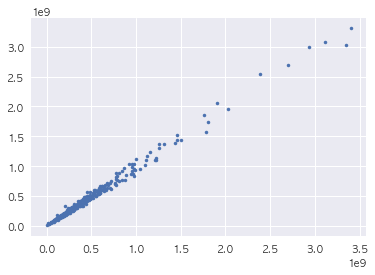

In [340]:
# 예측 vs 실제데이터 plot
y_pred = model.predict(x_test)
plt.plot(y_test, y_pred, '.')

# 예측과 실제가 비슷하면, 라인상에 분포함
x = np.linspace(0,330,100)
y = x
plt.plot(x,y)
plt.show()

In [341]:
'''
    MSE: 2825554942552948.5
    train R-square: 0.98
    test R-square: 0.99
'''

'\n    MSE: 2825554942552948.5\n    train R-square: 0.98\n    test R-square: 0.99\n'

In [342]:
# 다중공선성이 의심되는 변수: Final_auction_date, Close_date, Total_appraisal_price, Minimum_sales_price
# 수치가 가장 높게 나온 Final_auction_date를 삭제하고 측정해보자.
data2 = data.drop(['Final_auction_date'], axis=1)
data_x = data2.drop(['Hammer_price'],axis=1)
data_y = pd.DataFrame(data2['Hammer_price'], columns=['Hammer_price'])


In [343]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=0)


In [344]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_train, y_train)

0.9852781906908777

In [345]:
sk.metrics.mean_squared_error(y_train, model.predict(x_train))

2830351383296682.5

In [346]:
model.score(x_test, y_test)

0.990893174955869

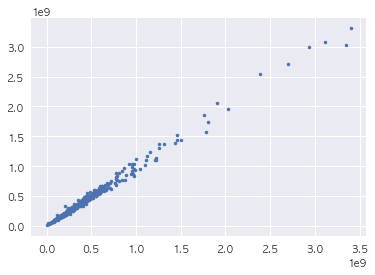

In [347]:
# 예측 vs 실제데이터 plot
y_pred = model.predict(x_test)
plt.plot(y_test, y_pred, '.')

# 예측과 실제가 비슷하면, 라인상에 분포함
x = np.linspace(0,330,100)
y = x
plt.plot(x,y)
plt.show()

In [348]:
'''
    MSE: 2830351383296682.5
    train R-square: 0.98
    test R-square: 0.99
'''

'\n    MSE: 2830351383296682.5\n    train R-square: 0.98\n    test R-square: 0.99\n'

In [349]:
# Final_auction_date를 삭제한 후 다중공선성 체크
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data_x.values, i) for i in range(data_x.shape[1])]

vif['features'] = data_x.columns
vif.sort_values(['VIF Factor'], ascending=[False])

,VIF Factor,features
11,25.988752,Total_appraisal_price
12,25.734048,Minimum_sales_price
13,6.708756,First_auction_date
3,3.856080,Appraisal_date
24,3.015818,Close_date
5,2.071390,Auction_miscarriage_count
10,2.027505,Total_building_auction_area
4,2.002354,Auction_count
9,1.994701,Total_building_area
0,1.424417,Auction_key


Final_auction_data를 삭제하고 다시 다중공선성을 확인하니 Close_date의 수치가 낮아졌다. <br/>
이번에는 재측정한 다중공선성 수치 중 가장 높은 Total_appraisal_price를 삭제해보자.

In [350]:
data3 = data2.drop(['Total_appraisal_price'], axis=1)
data_x = data3.drop(['Hammer_price'],axis=1)
data_y = pd.DataFrame(data3['Hammer_price'], columns=['Hammer_price'])

In [351]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

In [352]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_train, y_train)

0.9839655581351977

In [353]:
sk.metrics.mean_squared_error(y_train, model.predict(x_train))

3082712441079650.5

In [354]:
model.score(x_test, y_test)

0.9878816317392612

In [355]:
# Final_auction_date, Total_appraisal_price를 삭제한 후 다중공선성 체크
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data_x.values, i) for i in range(data_x.shape[1])]

vif['features'] = data_x.columns
vif.sort_values(['VIF Factor'], ascending=[False])

,VIF Factor,features
12,6.418448,First_auction_date
3,3.841884,Appraisal_date
23,2.883070,Close_date
10,1.893458,Total_building_auction_area
9,1.848391,Total_building_area
0,1.423368,Auction_key
8,1.299197,Total_land_auction_area
7,1.293414,Total_land_real_area
20,1.287586,Total_floor
4,1.212453,Auction_count


In [362]:
'''
    MSE: 3082712441079650.5
    train R-square: 0.98
    test R-square: 0.98
'''

'\n    MSE: 3082712441079650.5\n    train R-square: 0.98\n    test R-square: 0.98\n'

다중공선성 수치는 안정화되었지만 MSE는 더 커졌고, R-square는 변함이 없다. <br/>
다중공선성을 방지하기 위해 이 모델을 사용하기로 한다.

In [357]:
# Ridge, Lasso 회귀
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
ridge.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [358]:
ridge.get_params

<bound method BaseEstimator.get_params of Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)>

In [359]:
# R-square
ridge.score(x_train, y_train)

0.9856235538570951

In [360]:
# Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(x_train, y_train)
lasso.score(x_train, y_train)

0.9856255706318449

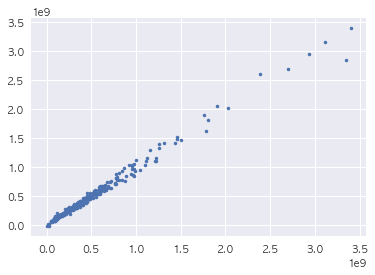

In [361]:
# 정규화된 데이터를 적용시켜보자 (lasso)
# 예측 vs 실제데이터 plot
y_pred = lasso.predict(x_test)
plt.plot(y_test, y_pred, '.')

# 예측과 실제가 비슷하면, 라인상에 분포함
x = np.linspace(0,330,100)
y = x
plt.plot(x,y)
plt.show()

#### 결과해석
독립변수와 종속변수는 강한 상관관계를 보인다. <br/>
test R-square가 높게 나왔기 때문에 나쁘지 않은 모델으로 보았다. <br/>
MSE는 종속변수의 단위에 따라 클 수도, 작을 수도 있다.